<a href="https://colab.research.google.com/github/mohamedhasssan/global-food-price-analysis/blob/main/notebooks/anomaly_detection_and_analytical_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 3 – Anomaly Detection and Analytical Metrics
### Global Food Price Anomaly Analysis

## Notebook Purpose
This notebook implements the anomaly detection and volatility metrics necessary to identify unusual movements in global food price indices.

### Objectives
- Load cleaned long-format dataset from Sprint 2
- Compute baseline statistical diagnostics
- Create rolling mean and rolling volatility metrics
- Define anomaly thresholds per commodity
- Produce anomaly flags
- Visualize anomalies
- Generate summary tables that will support consulting-level insights


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/mohamedhasssan/global-food-price-analysis/refs/heads/main/data/food_price_clean_long.csv"
df_long = pd.read_csv(url, parse_dates=['date'])


## Background – Understanding Global Food Commodity Dynamics

Before interpreting price behaviour, it is necessary to understand the basic drivers of global food commodities.

### Food Price Index (FPI)
A composite index published by FAO that tracks international prices of a basket of food commodities. It reflects overall global food inflation.

### Key Commodity Dynamics
- **Oils**: Highly sensitive to energy markets, biodiesel demand, and geopolitical disruptions.
- **Cereals**: Influenced by weather patterns, global crop yields, and trade policies.
- **Dairy**: Affected by feed costs, production cycles, and supply chain issues.
- **Meat**: Relatively stable due to slower production cycles and consistent demand.
- **Sugar**: Generally stable but vulnerable to extreme weather events in producing regions.


In [36]:
summary = df_long.groupby('commodity')['index_value'].describe()
summary


,count,mean,std,min,25%,50%,75%,max
commodity,,,,,,,,
cereals,431.0,89.586543,31.630097,48.60,60.600,88.30,111.700,173.5
dairy,431.0,88.591415,34.968928,36.80,57.500,81.70,117.200,158.2
food_price_index,431.0,89.034107,27.204357,50.80,64.650,87.00,116.350,160.2
meat,431.0,87.364733,18.450267,52.30,73.400,85.10,101.250,128.1
oils,431.0,93.550209,39.863284,35.83,63.895,83.17,120.485,251.8
sugar,431.0,84.901624,32.764073,31.80,60.100,78.70,108.400,183.2


<Axes: xlabel='commodity'>

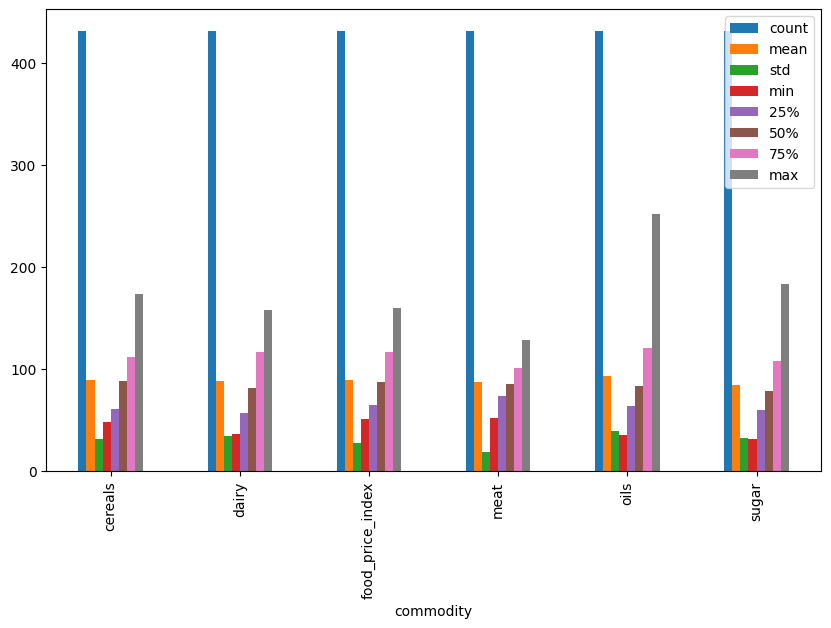

In [37]:
summary.plot(kind='bar', figsize=(10, 6))

### Interpretation
The descriptive statistics show clear volatility patterns across global food commodities.


1.   Oils Exhibit the highest volatility with the widest rage between minimum and maximum values and the largest standard deviation. Based on domain knowledge this indicates disruptions in the energy markets and geopolitical disruptions.
2.   Cereals, Dairy and Sugar have medium to high volatility showing effects due to weather, supply chain issues and trade policies
3.  Meat is the most stable of the commodities showing consistent demand vs production.
4.  Overall food_price_index show combined volatility but is potentially affected more by inflation cycles and larger supply chain issues like war and pandemics.




## Monthly Percent Change Metric

In [38]:
df_long['pct_change'] = (
    df_long.groupby('commodity')['index_value'].pct_change() * 100
)
df_long.head()


,date,commodity,index_value,pct_change
0,1990-01-01,food_price_index,64.4,NaN
1,1990-02-01,food_price_index,64.7,0.465839
2,1990-03-01,food_price_index,64.0,-1.081917
3,1990-04-01,food_price_index,66.0,3.125000
4,1990-05-01,food_price_index,64.6,-2.121212


## Rolling Mean and Rolling Standard Deviation

In [39]:
df_long['roll_mean_3']=df_long.groupby('commodity')['index_value'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_long['roll_std_3']=df_long.groupby('commodity')['index_value'].transform(lambda x: x.rolling(window=3, min_periods=1).std())

In [40]:
df_long.head()

,date,commodity,index_value,pct_change,roll_mean_3,roll_std_3
0,1990-01-01,food_price_index,64.4,NaN,64.400000,NaN
1,1990-02-01,food_price_index,64.7,0.465839,64.550000,0.212132
2,1990-03-01,food_price_index,64.0,-1.081917,64.366667,0.351188
3,1990-04-01,food_price_index,66.0,3.125000,64.900000,1.014889
4,1990-05-01,food_price_index,64.6,-2.121212,64.866667,1.026320


## Define Anomaly Thresholds

In [83]:
df_long['upper_bound'] = df_long['roll_mean_3'] + 1.152 * df_long['roll_std_3']
df_long['lower_bound'] = df_long['roll_mean_3'] - 1.152 * df_long['roll_std_3']

df_long['anomaly']=(
    (df_long['index_value'] > df_long['upper_bound']) |
    (df_long['index_value'] < df_long['lower_bound'])

)

In [84]:
df_long.head()

,date,commodity,index_value,pct_change,roll_mean_3,roll_std_3,upper_bound,lower_bound,anomaly
0,1990-01-01,food_price_index,64.4,NaN,64.400000,NaN,NaN,NaN,False
1,1990-02-01,food_price_index,64.7,0.465839,64.550000,0.212132,64.794376,64.305624,False
2,1990-03-01,food_price_index,64.0,-1.081917,64.366667,0.351188,64.771236,63.962098,False
3,1990-04-01,food_price_index,66.0,3.125000,64.900000,1.014889,66.069152,63.730848,False
4,1990-05-01,food_price_index,64.6,-2.121212,64.866667,1.026320,66.048988,63.684346,False


## Plotting Template for Anomalies

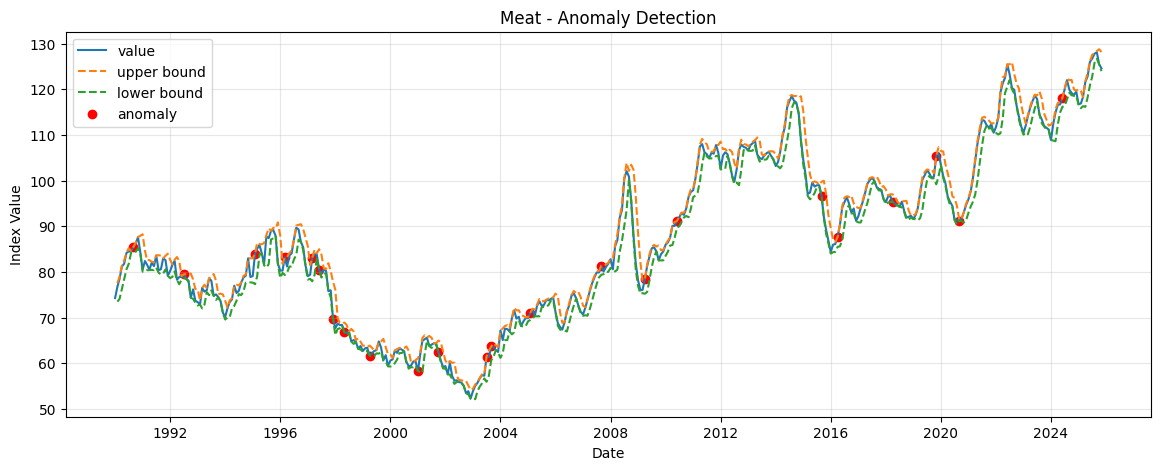

In [85]:
commodity = "meat"  # change to any commodity

subset = df_long[df_long['commodity'] == commodity]

plt.figure(figsize=(14,5))
plt.plot(subset['date'], subset['index_value'], label='value')
plt.plot(subset['date'], subset['upper_bound'], linestyle='--', label='upper bound')
plt.plot(subset['date'], subset['lower_bound'], linestyle='--', label='lower bound')

# plot anomalies
anoms = subset[subset['anomaly']]
plt.scatter(anoms['date'], anoms['index_value'], color='red', label='anomaly')

plt.title(f"{commodity.capitalize()} - Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Plotting: food_price_index


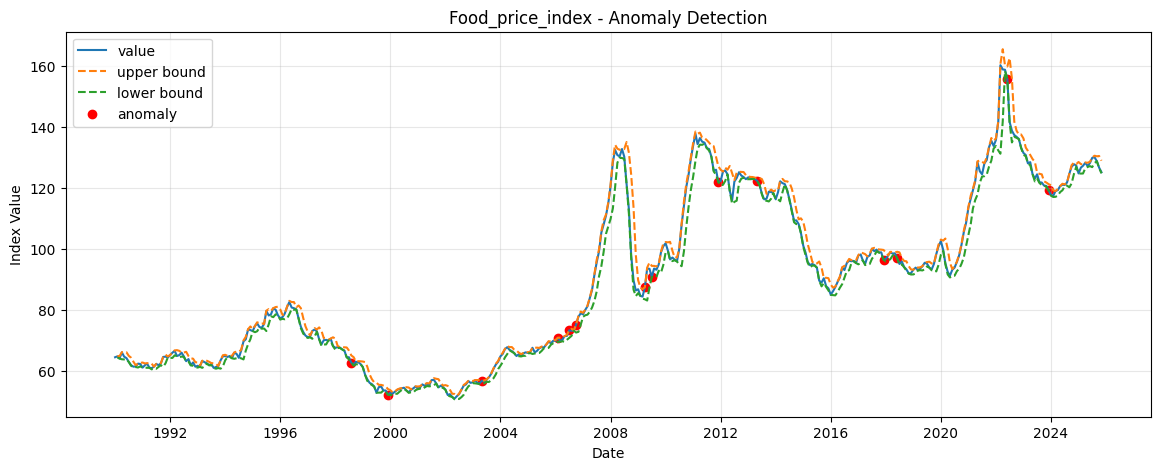

Plotting: meat


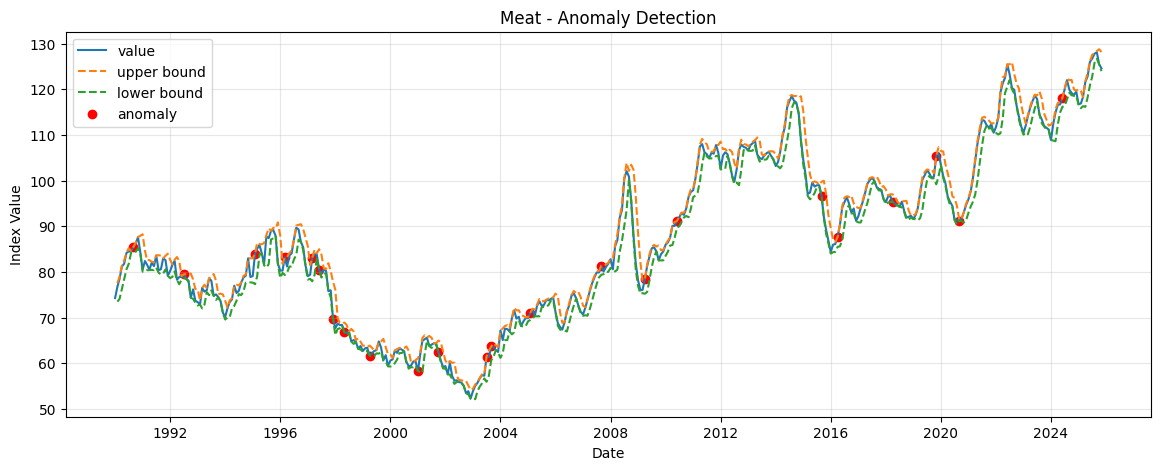

Plotting: dairy


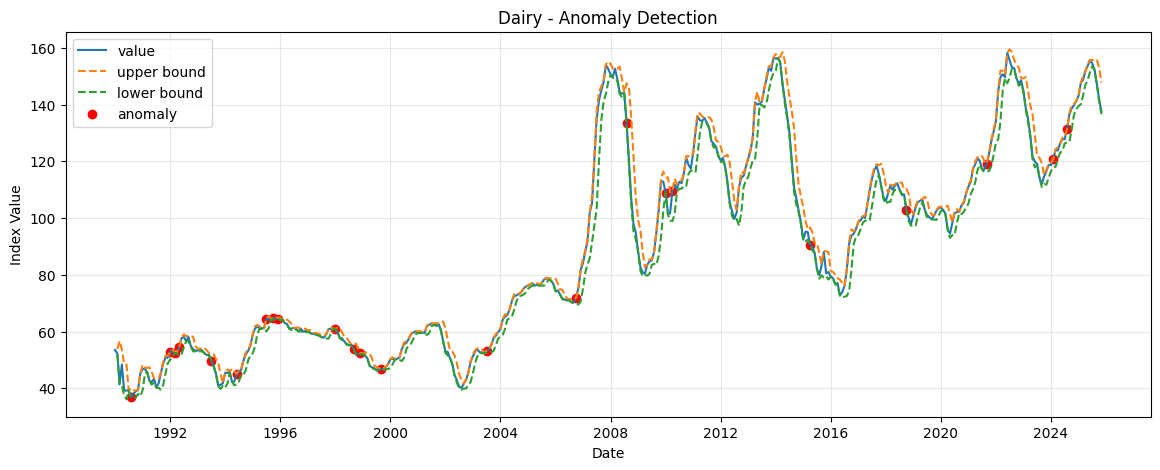

Plotting: cereals


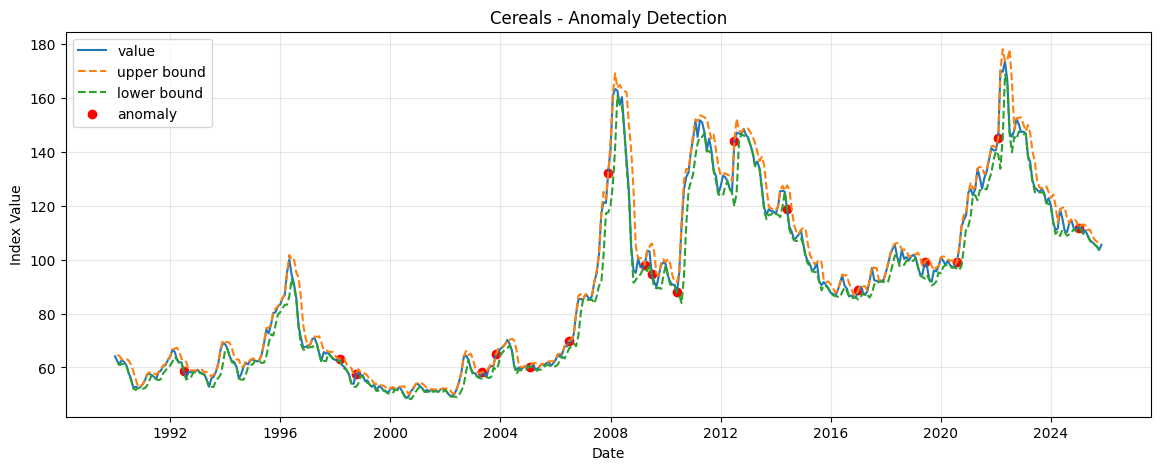

Plotting: oils


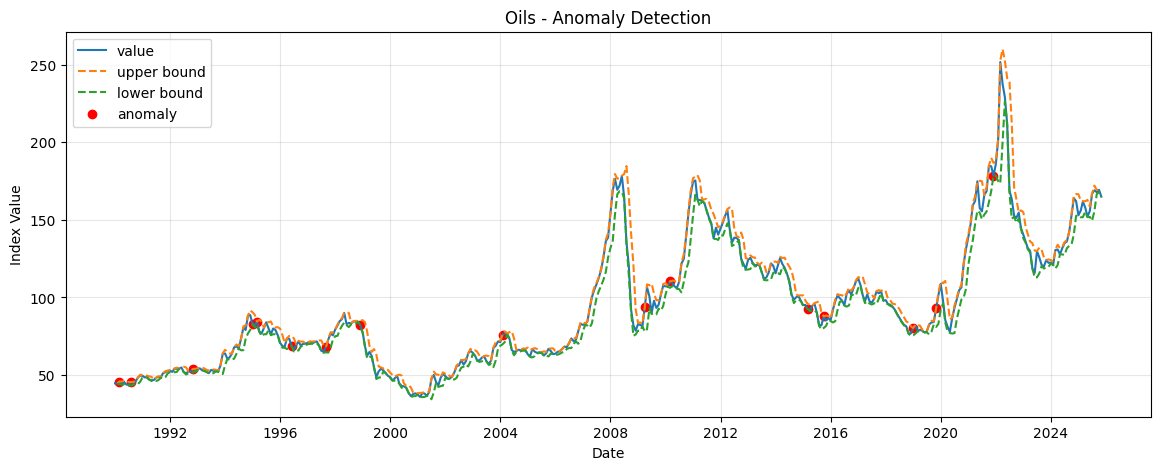

Plotting: sugar


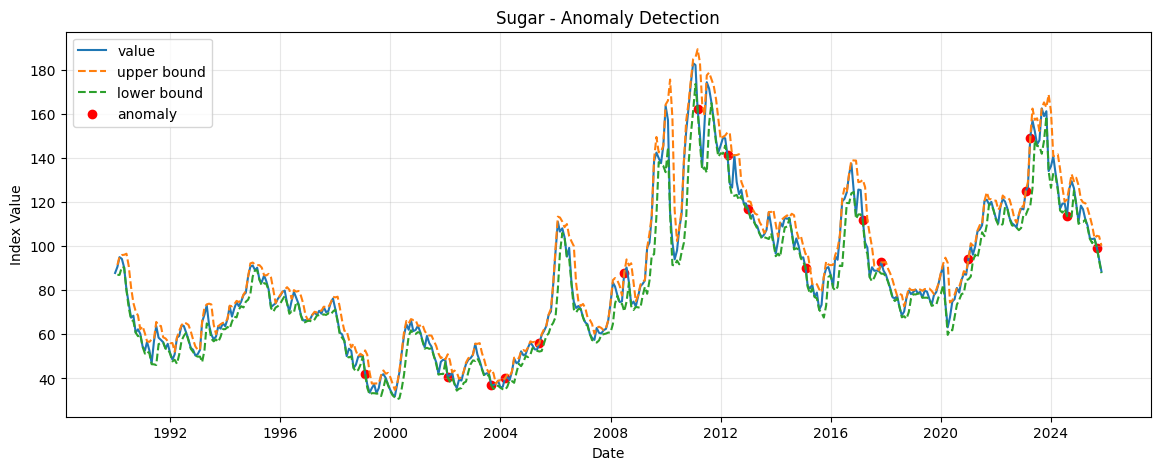

In [86]:
for c in df_long['commodity'].unique():
    print("Plotting:", c)
    subset = df_long[df_long['commodity'] == c]

    plt.figure(figsize=(14,5))
    plt.plot(subset['date'], subset['index_value'], label='value')
    plt.plot(subset['date'], subset['upper_bound'], linestyle='--', label='upper bound')
    plt.plot(subset['date'], subset['lower_bound'], linestyle='--', label='lower bound')

    anoms = subset[subset['anomaly']]
    plt.scatter(anoms['date'], anoms['index_value'], color='red', label='anomaly')

    plt.title(f"{c.capitalize()} - Anomaly Detection")
    plt.xlabel("Date")
    plt.ylabel("Index Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [87]:
anomaly_summary = df_long.groupby('commodity')['anomaly'].sum()
anomaly_summary


,anomaly
commodity,
cereals,18
dairy,23
food_price_index,14
meat,23
oils,16
sugar,17


### Interpretation

The z score value of 1.152 produces significant anomalies across commodities. it produced enough positives to consider and move forward. Dairy and mean seems to have the highest anomalies shown which is in line with supply chain disruptions due to diseases and other factors. Sugar, oil and cereals are moderate between 16 and 18 anomalies reflecting periodic market shocks. The composite foo price index shows 14 anomalies consistent with the smoothing effects of aggregating the other commodities. This threshhold identifies meaningful deviations while avoiding over triggering.

In [91]:
df_long.to_csv('food_price_analytics.csv', index=False)